In [37]:
# Exercise 1b
#### Lars Kühmichel, Ergin Kohen Sagner, Nicolas Wolf

## 3 Nearest Neighbor Classification on Real Data
### 3.1 Exploring the Data

In [38]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

print(type(data))
print(data.dtype)

print(f"The Images have size {images.shape[1]}x{images.shape[2]}")

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
<class 'numpy.ndarray'>
float64
The Images have size 8x8


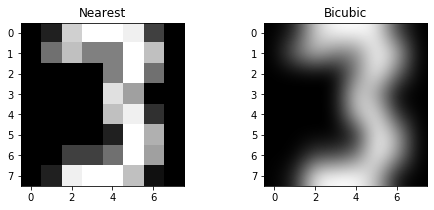

In [39]:
import numpy as np
from matplotlib import pyplot as plt

img = images[1220]
assert 2 == len(img.shape)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(img, interpolation="nearest", cmap="gray")
axes[0].set_title("Nearest")
axes[1].imshow(img, interpolation="bicubic", cmap="gray")
axes[1].set_title("Bicubic")
plt.show()

In [40]:
from sklearn import model_selection

x_all = data
y_all = target

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    digits.data, digits.target, test_size=0.4, random_state=0
)

### 3.2 Distance function computation using loops

In [41]:
import unittest


def distance(tr, te):
    return np.linalg.norm(tr - te)

def dist_loop(training, test):
    # writing this hurt my soul
    return np.array([
        [distance(tr, te) for te in test] for tr in training
    ])


class DistanceTest:
    def setUp(self):
        self.N = 2
        self.M = 3
        self.D = 3
        self.training = np.array([
            [1, 2, 3],
            [3, 4, 5]
        ])
        self.test = np.array([
            [3, 4, 5],
            [1, 2, 3],
            [7, 1, 4],
        ])

        self.distances = None

    def test_scipy(self):
        from scipy.spatial import distance_matrix

        distances_scipy = distance_matrix(self.training, self.test)
        self.assertTrue(np.allclose(distances_scipy, self.distances))

    def test_dimensions(self):
        self.assertEqual(self.N, self.training.shape[0])
        self.assertEqual(self.D, self.training.shape[1])
        self.assertEqual(self.M, self.test.shape[0])
        self.assertEqual(self.D, self.training.shape[1])
        self.assertEqual(self.N, self.distances.shape[0])
        self.assertEqual(self.M, self.distances.shape[1])

    def test_distance(self):
        self.assertTrue(np.allclose(np.array([
            [2 * np.sqrt(3), 0.0, np.sqrt(38)],
            [0.0, 2 * np.sqrt(3), np.sqrt(26)]
        ]), self.distances))

        distances = dist_loop(self.training, self.training)
        # values on the diagonal should be zero
        self.assertTrue(np.allclose(np.zeros_like(distances), np.diag(distances)))

class DistanceLoopTest(DistanceTest, unittest.TestCase):
    def setUp(self):
        super().setUp()
        self.distances = dist_loop(self.training, self.test)

# need some extra args here to run tests in Jupyter Notebooks
unittest.main(argv=[""], exit=False)


.......
----------------------------------------------------------------------
Ran 7 tests in 0.021s

OK


### 3.3 Distance Function using vectorization

In [42]:
def gen_data(n, m, d):
    training = np.random.uniform(low=0.0, high=10.0, size=(n, d))
    test = np.random.uniform(low=0.0, high=10.0, size=(m, d))

    return training, test

def dist_vec(training, test):
    # reshape the arrays such that subtraction yields all possible combinations
    diff = np.reshape(training, (training.shape[0], 1, -1)) - np.reshape(test, (1, test.shape[0], -1))
    distances = np.linalg.norm(diff, axis=2)
    return distances

class DistanceVectorTest(DistanceTest, unittest.TestCase):
    def setUp(self):
        super().setUp()
        self.distances = dist_vec(self.training, self.test)

    def test_comparison(self):
        training, test = gen_data(30, 45, 20)

        distances_loop = dist_loop(training, test)
        distances_vec = dist_vec(training, test)

        self.assertTrue(np.allclose(distances_loop, distances_vec))


unittest.main(argv=[""], exit=False)




.......
----------------------------------------------------------------------
Ran 7 tests in 0.021s

OK


#### Verify `dist_vec` is faster

In [43]:
tfeatures, test = gen_data(45, 65, 35)

# %timeit dist_loop(training, test)
# %timeit dist_vec(training, test)

### 3.4 Implement the k-nearest neighbor classifier

In [44]:
class KNNClassifier:
    def __init__(self, k, tfeatures, tlabels):
        self.k = k
        self.tfeatures = tfeatures
        self.tlabels = tlabels

    def __predict_label(self, labels):
        # count occurrences of unique labels
        unique, counts = np.unique(labels, return_counts=True)
        # return the label with the most occurrences
        return unique[counts.argmax()]

    def predict(self, features):
        distances = dist_vec(self.tfeatures, features)

        # get index matrix of k nearest neighbors
        knn_idx = np.argpartition(distances, self.k, axis=0)[:self.k]

        knn = self.tlabels[knn_idx]

        # features are colums, so transpose knn to give
        # concurrent arrays to __predict_label
        predicted_labels = np.array([self.__predict_label(col) for col in knn.T])

        return predicted_labels

#### Test the `KNNClassifier`

The classifier typically guesses 0-1 digits incorrectly, on a test set size of 72.

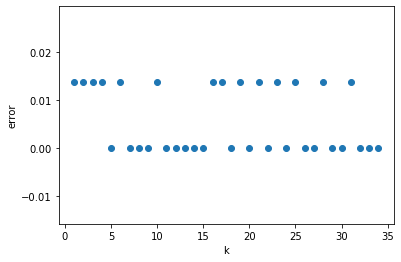

In [45]:
# filter the dataset to only contain 3s and 9s
tn = np.logical_or(target == 3, target == 9)

# use this to use the whole dataset
# tn = np.ones_like(target)

tn_data = data[tn]
tn_target = target[tn]

# 80% training, 20% testing
tn_x_train, tn_x_test, tn_y_train, tn_y_test = model_selection.train_test_split(
    tn_data, tn_target, test_size=0.2, random_state=0
)

ks = np.arange(1, 35)
errors = []

for k in ks:
    c = KNNClassifier(k, tn_x_train, tn_y_train)

    tn_y_predicted = c.predict(tn_x_test)

    incorrect = tn_y_predicted != tn_y_test

    error = np.mean(incorrect)

    errors.append(error)

plt.scatter(ks, errors)
plt.xlabel("k")
plt.ylabel("error")
plt.show()



